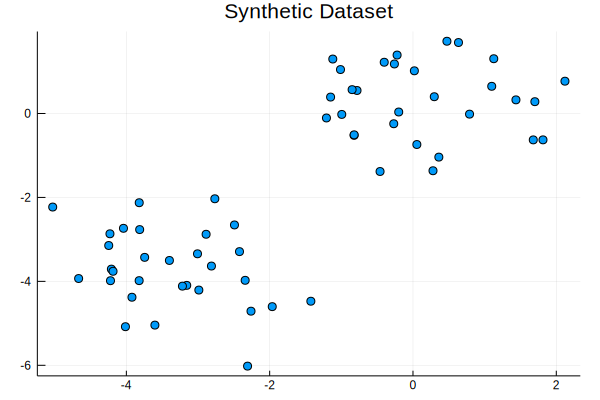

In [6]:
using Distributions, StatPlots, Random

# Set a random seed.
Random.seed!(3)

# Construct 100 data points for each cluster.
N = 30

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0, 1.2]

# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], 1.), N), hcat, 1:2)

# Visualization.
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

In [7]:
using Turing, MCMCChain

┌ Info: Recompiling stale cache file /Users/andreatitton/.julia/compiled/v1.0/Turing/gm4QC.ji for Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1184


In [8]:
@model GaussianMixtureModel(x) = begin
    D, N = size(x)
    
    µ1 ~ Normal()
    µ2 ~ Normal()
    
    µ = [µ1, µ2]
    
    w = [0.5,0.5]
    
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([µ[k[i]], µ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 2 methods)

In [10]:
Turing.setadbackend(:forward_diff)

:forward_diff

In [11]:
gmm_model = GaussianMixtureModel(x)

┌ Info:  Assume - `μ1` is a parameter
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/core/compiler.jl:135
┌ Info:  Assume - `μ2` is a parameter
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/core/compiler.jl:135
┌ Info:  Assume - `k` is a parameter
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/core/compiler.jl:165
┌ Info:  Observe - `x` is an observation
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/core/compiler.jl:153


GaussianMixtureModel_model (generic function with 4 methods)

In [12]:
gmm_sampler = Gibbs(100, PG(100, 1, :k), HMC(1, 0.05, 10, :µ1, :µ2))
tchain = sample(gmm_model, gmm_sampler)


[Gibbs] Sampling...100% Time: 0:03:06
┌ Info: [Gibbs] Finished with
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/samplers/gibbs.jl:163
┌ Info:   Running time    = 185.59644873099992;
└ @ Turing /Users/andreatitton/.julia/packages/Turing/u2n4Y/src/samplers/gibbs.jl:164


Turing.Chain{AbstractRange{Int64}}(0.0, Turing.Sample[Sample(0.01, Dict{Symbol,Any}(Symbol("k[3]")=>2,Symbol("k[19]")=>1,Symbol("k[2]")=>2,:μ2=>0.359874,Symbol("k[6]")=>1,Symbol("k[37]")=>2,Symbol("k[21]")=>2,Symbol("k[7]")=>2,Symbol("k[42]")=>2,Symbol("k[41]")=>1…)), Sample(0.01, Dict{Symbol,Any}(Symbol("k[3]")=>2,Symbol("k[19]")=>1,Symbol("k[2]")=>2,:μ2=>-2.9205,Symbol("k[6]")=>1,Symbol("k[37]")=>2,Symbol("k[21]")=>2,Symbol("k[7]")=>2,Symbol("k[42]")=>1,Symbol("k[41]")=>1…)), Sample(0.01, Dict{Symbol,Any}(Symbol("k[3]")=>1,Symbol("k[19]")=>2,Symbol("k[2]")=>2,:μ2=>-0.995839,Symbol("k[6]")=>2,Symbol("k[37]")=>2,Symbol("k[21]")=>2,Symbol("k[7]")=>1,Symbol("k[42]")=>2,Symbol("k[41]")=>2…)), Sample(0.01, Dict{Symbol,Any}(Symbol("k[3]")=>1,Symbol("k[19]")=>2,Symbol("k[2]")=>2,:μ2=>-0.95713,Symbol("k[6]")=>2,Symbol("k[37]")=>2,Symbol("k[21]")=>2,Symbol("k[7]")=>1,Symbol("k[42]")=>2,Symbol("k[41]")=>2…)), Sample(0.01, Dict{Symbol,Any}(Symbol("k[3]")=>1,Symbol("k[19]")=>2,Symbol("k[2]")=>2,:

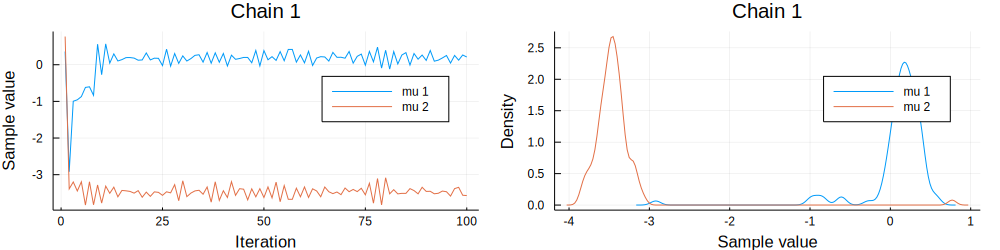

In [13]:
ids = findall(map(name -> occursin("μ", name), tchain.names));
plot(Chains(tchain.value[:,ids,:], names = ["mu 1", "mu 2"]), colordim = :parameter, legend = true)

In [15]:
function predict(x, y, w, μ)
    # Use log-sum-exp trick for numeric stability.
    return Turing.logsumexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x, y]), 
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x, y])
    )
end

predict (generic function with 1 method)

┌ Warning: `logsumexp(x::Real, y::Real)` is deprecated, use `logaddexp(x, y)` instead.
│   caller = predict(::Int64, ::Int64, ::Array{Float64,1}, ::Array{Float64,1}) at In[15]:3
└ @ Main ./In[15]:3


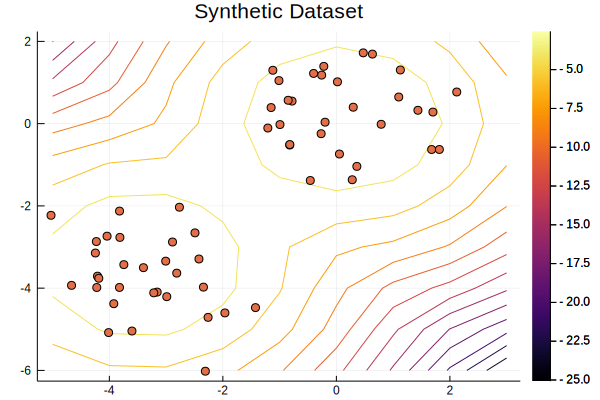

In [16]:
contour(range(-5, stop = 3), range(-6, stop = 2), 
    (x, y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1]), mean(tchain[:μ2])])
)
scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

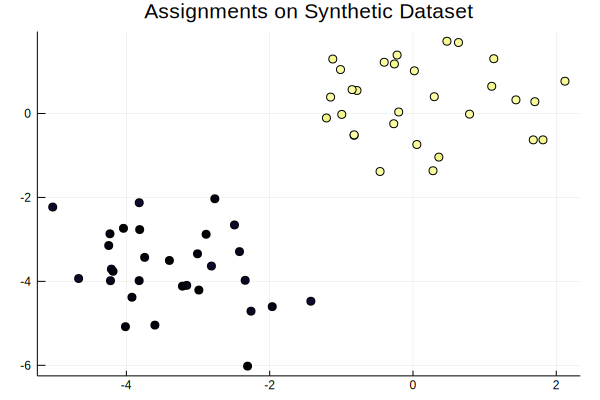

In [17]:
scatter(x[1,:], x[2,:], legend = false, title = "Assignments on Synthetic Dataset", zcolor = mean(tchain[:k]))
